In [1]:
import os

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
f = gzip.GzipFile(r"../../Data/rBergomiTrainSet.txt.gz", "r")
dat=np.load(f)
xx=dat[:,:4]
yy=dat[:,4:]
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])
maturities=np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


x_train, x_test, y_train, y_test = train_test_split(
    xx, yy, test_size=0.15, random_state=42)

In [3]:
def append_and_expand(a,x,y):
    # use choose and where !
    n = len(x)*len(y)
    a_index = np.arange(len(a))%n
    
    
    x_index = a_index//len(y)
    y_index = a_index%len(y)
    
    x_added = np.choose(x_index,x.reshape(-1,1)).reshape(-1,1)
    y_added = np.choose(y_index,y.reshape(-1,1)).reshape(-1,1)
    
    return np.hstack([a,x_added,y_added])

y_train,y_test = y_train.reshape(-1,8,11),y_test.reshape(-1,8,11)
x_train,x_test = np.repeat(x_train, 8*11,axis=0),np.repeat(x_test, 8*11,axis=0)

In [4]:
x_train,x_test=append_and_expand(x_train,maturities,strikes),append_and_expand(x_test,maturities,strikes)
y_train,y_test = y_train.reshape(-1).reshape(-1,1), y_test.reshape(-1).reshape(-1,1)

In [5]:
import torch
import torch.nn as nn

scale_y=  StandardScaler()

def ytransform(y_train,y_test):
    return [scale_y.fit_transform(y_train),scale_y.transform(y_test)]

def yinversetransform(y):
    return scale_y.inverse_transform(y)

# Upper and lower bounds used in the training set
ub=np.array([0.16,4,-0.1,0.5,2.0,1.5])
lb=np.array([0.01,0.3,-0.95,0.025,0.1,0.5])

def myscale(x):
    return (x - (ub+lb)*0.5)*2/(ub-lb)
def myinverse(x):
    return x*(ub-lb)*0.5+(ub+lb)*0.5

x_train_transform = myscale(x_train)
x_test_transform = myscale(x_test)
[y_train_transform,y_test_transform] = ytransform(y_train,y_test)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device is {device}")

train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train_transform).to(device=device),
                                               torch.from_numpy(y_train_transform).to(device=device))
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test_transform).to(device=device),
                                              torch.from_numpy(y_test_transform).to(device=device))


train_data = (torch.from_numpy(x_train_transform).to(device=device),torch.from_numpy(y_train_transform).to(device=device))
test_data = (torch.from_numpy(x_test_transform).to(device=device),torch.from_numpy(y_test_transform).to(device=device))

data_loader = torch.utils.data.DataLoader(train_dataset,batch_size =88,shuffle=False)

device is cuda


In [6]:
import sys
sys.path.append('../../')  # Add the parent directory to the Python path

from torch_NN.nn import ResNN_pricing

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

hyperparas = {'input_dim':6,'hidden_dim':64,'hidden_nums':10,'output_dim':1,'block_layer_nums':3}

model = ResNN_pricing(hyperparas=hyperparas).to(device=device,dtype=torch.float64)

loss_MSE = nn.MSELoss()
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.0001)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 31.156474178896744
test loss is 30.606977827973218
Batch: 100,train loss is: 0.7649635856511395
test loss is 0.5948405447769134
Batch: 200,train loss is: 0.24970110095104248
test loss is 0.320732422210515
Batch: 300,train loss is: 0.11754152049552177
test loss is 0.22375495942034973
Batch: 400,train loss is: 0.04698420463815498
test loss is 0.16758846367267985
Batch: 500,train loss is: 0.035451536867497316
test loss is 0.20793402800558755
Batch: 600,train loss is: 0.0158520087502169
test loss is 0.10674091613938971
Batch: 700,train loss is: 0.026357052593868203
test loss is 0.09657108887458654
Batch: 800,train loss is: 0.048291075913838806
test loss is 0.08036734397736131
Batch: 900,train loss is: 0.07352593843935042
test loss is 0.06753446116296673
Batch: 1000,train loss is: 0.05217992400472053
test loss is 0.059058582658887984
Batch: 1100,train loss is: 0.17038690341984858
test loss is 0.0530723

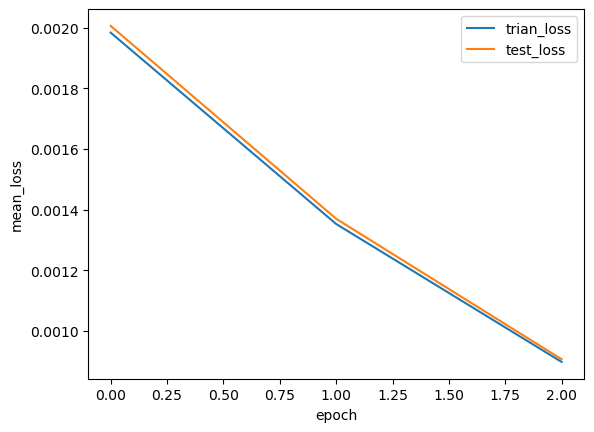

In [7]:
from torch_NN.train import train_model

train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,3)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.0007537674559484046
test loss is 0.000859589918262441
Batch: 100,train loss is: 0.001383027451107782
test loss is 0.001168932036503983
Batch: 200,train loss is: 0.000681544914988162
test loss is 0.0008376153926205831
Batch: 300,train loss is: 0.0007164231324842057
test loss is 0.0007679996300259924
Batch: 400,train loss is: 0.0010438876921341272
test loss is 0.0017421162743357635
Batch: 500,train loss is: 0.0005488233315217334
test loss is 0.0015156034320609874
Batch: 600,train loss is: 0.00028338331473464737
test loss is 0.0010141185299885297
Batch: 700,train loss is: 0.0004750451954956375
test loss is 0.000859348743633431
Batch: 800,train loss is: 0.0002696539182703794
test loss is 0.001160051044463672
Batch: 900,train loss is: 0.0005240564114719962
test loss is 0.0008272023710494387
Batch: 1000,train loss is: 0.002892133280653025
test loss is 0.001105641962382108
Batch: 1100,train loss is: 0.

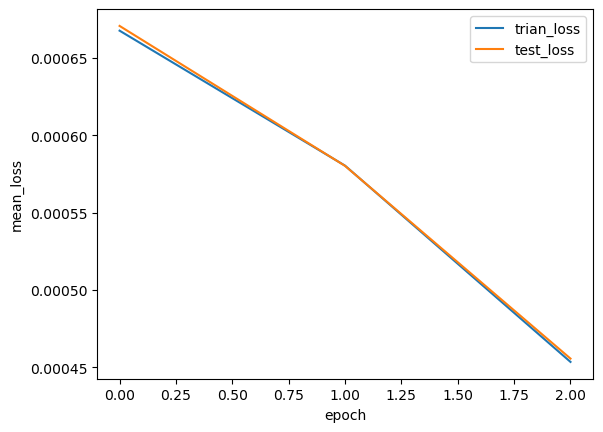

In [8]:
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,3)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.0004210850603232282
test loss is 0.0004289753421299835
Batch: 100,train loss is: 0.0004999100348358975
test loss is 0.00038617009205925006
Batch: 200,train loss is: 0.00025682252201726863
test loss is 0.0003168393814536375
Batch: 300,train loss is: 0.000255132847479449
test loss is 0.0003712478280225658
Batch: 400,train loss is: 0.0007039415541448007
test loss is 0.0012375722414230453
Batch: 500,train loss is: 0.00024853602936462775
test loss is 0.0007760825522319763
Batch: 600,train loss is: 0.00010608532828485901
test loss is 0.000549523461381982
Batch: 700,train loss is: 0.00026377819518345614
test loss is 0.00036689193464472
Batch: 800,train loss is: 0.00014978465587457568
test loss is 0.00044074464585414574
Batch: 900,train loss is: 0.0003956678519817975
test loss is 0.0004995601799630069
Batch: 1000,train loss is: 0.002747061352164178
test loss is 0.0008959545746163091
Batch: 1100,train lo

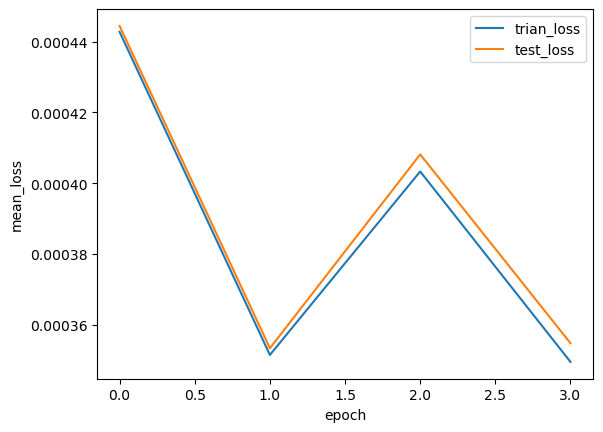

In [12]:
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,4)

-----------------------Epoch: 0----------------------------------
Batch: 0,train loss is: 0.00025688925011882187
test loss is 0.00035571089084992456
Batch: 100,train loss is: 0.00027952857599471674
test loss is 0.00019175619235531441
Batch: 200,train loss is: 0.000136786337436899
test loss is 0.0001808134941055253
Batch: 300,train loss is: 0.00013592883215825634
test loss is 0.00019425373996039797
Batch: 400,train loss is: 0.00011882415054616123
test loss is 0.00018194607443947777
Batch: 500,train loss is: 7.378989437010583e-05
test loss is 0.00017806670378682694
Batch: 600,train loss is: 5.040661251237643e-05
test loss is 0.00016399011623908773
Batch: 700,train loss is: 0.00011671261820995356
test loss is 0.00016941308688413488
Batch: 800,train loss is: 0.00012028922001346587
test loss is 0.00016630646802270622
Batch: 900,train loss is: 0.00010351479340031418
test loss is 0.0001723720350342117
Batch: 1000,train loss is: 0.00010394250851545853
test loss is 0.0001626858443479317
Batch: 

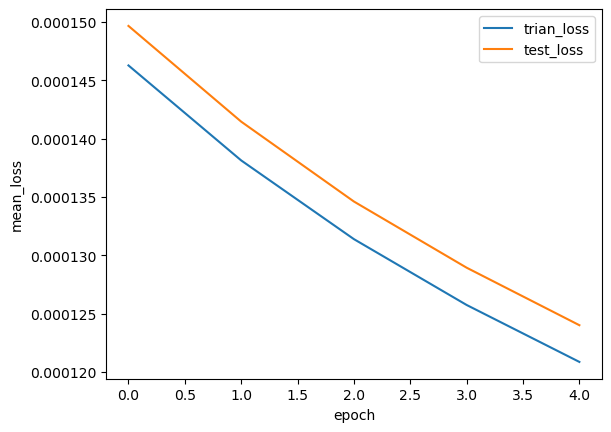

In [13]:
optim_Adam = torch.optim.Adam(model.parameters(),lr= 0.00001)
train_model(loss_MSE,optim_Adam,model,data_loader,train_data,test_data,5)

In [14]:
torch.save(model.state_dict(),'../../Data/YU/rflatBergomi_pointwise88.pth')